In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


def read_data(path, columns):
    df = pd.read_csv(
        path,
        sep=" ",
        names=columns,
        header=None,
        engine="python",
        skipinitialspace=True,
        index_col=False,
    )
    df.dropna(axis=1, how="all", inplace=True)
    return df


def get_raw_data(engine_name):
    path_train = f"CMAPSSData/train_{engine_name}.txt"
    path_test = f"CMAPSSData/test_{engine_name}.txt"
    path_test_rul = f"CMAPSSData/RUL_{engine_name}.txt"
    columns = (
        ["unit_number", "time_in_cycles"]
        + [f"operational_setting_{i}" for i in range(1, 4)]
        + [f"sensor_measurement_{i}" for i in range(1, 23)]
    )
    # Reading the file into a DataFrame
    df_train = read_data(path_train, columns)
    # linear degradation trend
    df_train["RUL"] = (
        df_train.groupby("unit_number")["time_in_cycles"].transform("max")
        - df_train["time_in_cycles"]
    )

    df_test = read_data(path_test, columns)
    test_rul = pd.read_csv(
        path_test_rul,
        sep=" ",
        names=["RUL"],
        header=None,
        engine="python",
        skipinitialspace=True,
        index_col=False,
    )
    df_test["RUL"] = test_rul["RUL"]
    return df_train, df_test


engine_1_data_train, engine_1_data_test = get_raw_data("FD001")
engine_2_data_train, engine_2_data_test = get_raw_data("FD002")
engine_3_data_train, engine_3_data_test = get_raw_data("FD003")
engine_4_data_train, engine_4_data_test = get_raw_data("FD004")

In [16]:
np.set_printoptions(suppress=True)

rul_max = 125

def get_data(df):
    features = df.copy().columns[
        5:-2
    ]  # Excluding unit number, time in cycles, RUL, operational settings
    # find and drop constant sensor measurement columns
    for col in features:
        if df[col].std() < 0.01:
            features = features.drop(col)
            print(col)
    return df[features].to_numpy()


def allocate_memory(data, num_sequences, sequence_length):
    return np.repeat(
        np.nan, repeats=sequence_length * num_sequences * data.shape[1]
    ).reshape(num_sequences, sequence_length, data.shape[1])


def get_train_targets(num_sequences_train):
    if num_sequences_train < rul_max:
        return np.arange(num_sequences_train - 1, -1, -1).tolist()
    return np.append(
        np.repeat(rul_max, num_sequences_train - rul_max),
        np.arange(rul_max - 1, -1, -1),
    ).tolist()


def create_sequences(
    train_input_data,
    test_input_data,
    sequence_length,
    num_test_windows=1,
    target_scaler=None,
):
    train_sequences = []
    test_sequences = []
    train_target_values = []
    test_target_values = []
    unit_indices_train = []
    unit_indices_test = []
    num_test_windows_per_unit = []

    scaler = MinMaxScaler(feature_range=(-1, 1))

    print(get_data(train_input_data).shape, get_data(test_input_data).shape)

    data_train = scaler.fit_transform(get_data(train_input_data))
    data_test = scaler.transform(get_data(test_input_data))

    unit_numbers_train = train_input_data["unit_number"].to_numpy()
    unit_numbers_test = test_input_data["unit_number"].to_numpy()

    targets_test_map = {
        unit: rul
        for unit, rul in zip(
            test_input_data["unit_number"].unique(), test_input_data["RUL"].to_numpy()
        )
    }

    unit_numbers = np.arange(
        1, min(np.unique(unit_numbers_train)[-1], np.unique(unit_numbers_test)[-1]) + 1
    )

    for unit_number in unit_numbers:
        # number of possible test and train sequences for this unit
        num_sequences_train = (
            np.count_nonzero(unit_numbers_train == unit_number) - sequence_length + 1
        )
        num_sequences_test = min(
            np.count_nonzero(unit_numbers_test == unit_number) - sequence_length + 1,
            num_test_windows,
        )

        assert num_sequences_test > 0, "Window size too large for unit"

        num_test_windows_per_unit.append(num_sequences_test)

        unit_targets = get_train_targets(num_sequences_train)
        train_target_values.extend(unit_targets)

        # pre allocate memory
        train_sequences.append(
            allocate_memory(data_train, num_sequences_train, sequence_length)
        )

        test_sequences.append(
            allocate_memory(data_test, num_sequences_test, sequence_length)
        )

        unit_index = (
            np.where(unit_numbers_train == unit_number)[0][0] if unit_number > 1 else 0
        )

        for seq_idx in range(num_sequences_train):
            end = seq_idx + sequence_length + unit_index
            start = seq_idx + unit_index
            train_sequences[-1][seq_idx] = data_train[start:end]
            unit_indices_train.append(unit_number)

        unit_index = np.where(unit_numbers_test == unit_number)[0][-1]

        # start from end
        for seq_idx in range(num_sequences_test):
            start = unit_index - seq_idx
            end = start - sequence_length + 1
            test_sequences[-1][seq_idx] = data_test[end : start + 1]
            test_target_values.append(targets_test_map[unit_number])
            unit_indices_test.append(unit_number)

    return (
        np.concatenate(train_sequences),
        target_scaler.fit_transform(
            np.array(train_target_values).reshape(-1, 1)
        ).reshape(-1),
        np.concatenate(test_sequences),
        np.array(test_target_values),
        np.array(unit_indices_train),
        np.array(unit_indices_test),
        np.array(num_test_windows_per_unit),
    )


target_scaler = MinMaxScaler(feature_range=(0, 1))

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def test_model_performance(model, X_test, engine_test, unit_indices_test, device):
    model.eval()
    preds = []
    true_rul = engine_test["RUL"].dropna().values
    with torch.no_grad():
        for data in X_test:
            # Move data to device
            data = torch.tensor(data).float().to(device).unsqueeze(0)

            output = model(data).squeeze().cpu().numpy()
            preds.append(
                target_scaler.inverse_transform(output.reshape(-1, 1)).reshape(-1)
            )

    preds_per_engine = {i + 1: [] for i in range(len(true_rul))}
    for i, pred in enumerate(preds):
        preds_per_engine[unit_indices_test[i]].append(pred)

    mean_preds_per_engine = [np.mean(preds) for preds in preds_per_engine.values()]

    RMSE = np.sqrt(mean_squared_error(true_rul, mean_preds_per_engine))
    return RMSE, mean_preds_per_engine, preds_per_engine, true_rul

In [18]:
best_scores = {i: {"RMSE": float("inf")} for i in range(1, 5)}

best_config_per_engine = {
    i: {"sequence_length": 0, "num_lstms": 0, "learning_rate": 0} for i in range(1, 5)
}

In [257]:
class RULPredictionModel(nn.Module):
    def __init__(self, num_features, hidden_size, num_lstms, num_classes=1):
        super(RULPredictionModel, self).__init__()
        self.num_lstms = num_lstms

        # Convolutional layers
        self.conv1 = nn.Conv1d(
            in_channels=num_features, out_channels=64, kernel_size=3, padding=1
        )
        self.conv2 = nn.Conv1d(
            in_channels=64, out_channels=128, kernel_size=3, padding=1
        )
        self.maxpool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv1d(
            in_channels=128, out_channels=128, kernel_size=5, padding=2
        )
        self.conv4 = nn.Conv1d(
            in_channels=128, out_channels=256, kernel_size=5, padding=2
        )
        self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        # Dropout layer
        self.dropout = nn.Dropout(0.5)

        for i in range(num_lstms):
            if i == 0:
                setattr(
                    self,
                    f"lstm{i+1}",
                    nn.LSTM(input_size=256, hidden_size=hidden_size, batch_first=True),
                )
            else:
                setattr(
                    self,
                    f"lstm{i+1}",
                    nn.LSTM(
                        input_size=hidden_size,
                        hidden_size=hidden_size,
                        batch_first=True,
                    ),
                )

        # Dense layer
        self.fc = nn.Linear(hidden_size, num_classes)

        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Reshape input data (batch_size, num_features, sequence_length)
        x = x.transpose(1, 2)

        # Convolutional layers with ReLU activations
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.maxpool1(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.maxpool2(x)

        # Dropout layer
        x = self.dropout(x)

        # Reshape output for LSTM layers
        # We need to make sure the LSTM input is (batch_size, seq_len, num_features)
        x = x.transpose(1, 2)

        # LSTM layers
        for i in range(self.num_lstms):
            x, _ = getattr(self, f"lstm{i+1}")(x)

        # Dropout layer
        x = self.dropout(x)

        # Take the output of the last time step
        x = x[:, -1, :]

        # Fully connected layer
        x = self.fc(x)
        return x


hidden_size = 32
criterion = nn.MSELoss()
batch_size = 64


def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs,
    engine_number,
    engine_test_data,
    engine_test_unit_indices,
    best_scores,
    best_config_per_engine,
    patience=3,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_val_loss = float("inf")
    early_stop_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for sequences, labels in train_loader:
            # Forward pass
            sequences = sequences.float().to(device)
            labels = labels.float().to(device)
            outputs = model(sequences).squeeze()
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for sequences, labels in val_loader:
                sequences = sequences.float().to(device)
                labels = labels.float().to(device)
                outputs = model(sequences).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        # Test the model's performance
        test_rmse, _, _, _ = test_model_performance(
            model, X_test, engine_test_data, engine_test_unit_indices
        )

        if test_rmse < best_scores[engine_number]["RMSE"]:
            best_scores[engine_number]["RMSE"] = test_rmse
            best_config_per_engine[engine_number].update(
                {
                    "sequence_length": sequence_length,
                    "num_lstms": num_lstms,
                    "learning_rate": lr,
                }
            )
            print(
                f"New best model found for engine {engine_number} w/ RMSE: {test_rmse}"
            )
            torch.save(model.state_dict(), f"best_saved_models/best_model_engine_{engine_number}_{round(test_rmse,2)}.pt")

        # Print epoch results
        print(
            f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, "
            f"Validation Loss: {val_loss/len(val_loader):.4f}",
            f"Test RMSE: {test_rmse:.4f}",
        )

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered!")
                break

# Hyperparameter ranges
engines_data = [
    (engine_1_data_train, engine_1_data_test),
    (engine_2_data_train, engine_2_data_test),
    (engine_3_data_train, engine_3_data_test),
    (engine_4_data_train, engine_4_data_test),
]
sequence_length_offsets = range(0, 15, 5)
num_lstms_options = [2, 3, 4]
learning_rates = [0.001, 0.0005, 0.0001]

# Helper function to set up data loaders
def setup_data_loaders(X_train, y_train, X_val, y_val, batch_size):
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(val_dataset, batch_size=batch_size)

# Find the maximum possible sequence length for a given engine based on the number of cycles in the test data
def get_max_possible_sequence_length(df_test):
    print(np.average(df_test.groupby("unit_number").size()))
    return df_test.groupby("unit_number").size().min()


# Function for saving best result dicts for future use
def save_best_results(best_scores, best_config_per_engine):
    with open("best_scores.json", "w") as f:
        json.dump(best_scores, f)
    with open("best_config_per_engine.json", "w") as f:
        json.dump(best_config_per_engine, f)


# Model training loop
for i, (data_train, data_test) in enumerate(engines_data):
    engine_number = i + 1
    print(f"Engine {engine_number}")
    max_sequence_length = get_max_possible_sequence_length(data_test)
    
    for offset in sequence_length_offsets:
        sequence_length = max_sequence_length - offset
        print(f"Sequence length: {sequence_length}")

        # Creating sequences
        X, y, X_test, y_test, unit_indices_test, num_test_windows_list = create_sequences(
            data_train, data_test, sequence_length, num_test_windows=5, target_scaler=target_scaler
        )
        
        # Splitting the data into training and validation sets (80-20 split)
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=83
        )
        train_loader, val_loader = setup_data_loaders(X_train, y_train, X_val, y_val, batch_size)
        num_features = X_train.shape[2]

        for num_lstms in num_lstms_options:
            for lr in learning_rates:
                print(f"Training with {num_lstms} LSTM layers and learning rate: {lr}")
                model = RULPredictionModel(num_features, hidden_size, num_lstms).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)
                
                train_model(
                    model, train_loader, val_loader, criterion, optimizer,
                    num_epochs=30, engine_number=engine_number, best_scores=best_scores, 
                    best_config_per_engine=best_config_per_engine, engine_test_data=data_test, 
                    engine_test_unit_indices=unit_indices_test, patience=3
                )

# Save best results
save_best_results(best_scores, best_config_per_engine)

Engine 1
130.96
Sequence length: 31
sensor_measurement_1
sensor_measurement_5
sensor_measurement_6
sensor_measurement_10
sensor_measurement_16
sensor_measurement_18
sensor_measurement_19
sensor_measurement_1
sensor_measurement_5
sensor_measurement_6
sensor_measurement_10
sensor_measurement_16
sensor_measurement_18
sensor_measurement_19
(20631, 13) (13096, 13)
sensor_measurement_1
sensor_measurement_5
sensor_measurement_6
sensor_measurement_10
sensor_measurement_16
sensor_measurement_18
sensor_measurement_19
sensor_measurement_1
sensor_measurement_5
sensor_measurement_6
sensor_measurement_10
sensor_measurement_16
sensor_measurement_18
sensor_measurement_19
Training with 2 LSTM layers and learning rate: 0.001
Epoch 1/30, Train Loss: 0.0696, Validation Loss: 0.0222 Test RMSE: 19.0580
Epoch 2/30, Train Loss: 0.0309, Validation Loss: 0.0155 Test RMSE: 15.5139
Epoch 3/30, Train Loss: 0.0245, Validation Loss: 0.0125 Test RMSE: 14.5757
Epoch 4/30, Train Loss: 0.0207, Validation Loss: 0.0130 Te

In [ ]:
import json

# Save for future use
with open("best_scores.json", "w") as f:
    json.dump(best_scores, f)

with open("best_config_per_engine.json", "w") as f:
    json.dump(best_config_per_engine, f)

print(best_scores, best_config_per_engine)


In [ ]:
### Modify to change testing engine
current_engine_config = best_config_per_engine[4]
model_path = f"best_saved_models/best_model_engine_4_{round(best_scores[4]['RMSE'],2)}.pt"
train_data = engine_4_data_train
test_data = engine_4_data_test
###################################

_, _, X_test, _, _, unit_indices_test, num_test_windows_list = create_sequences(
    train_data,
    test_data,
    sequence_length=current_engine_config["sequence_length"],
    num_test_windows=5,
    target_scaler=target_scaler,
)
num_features = X_test.shape[2]
model = RULPredictionModel(
    num_features, hidden_size, num_lstms=current_engine_config["num_lstms"]
).to(device)
model.load_state_dict(torch.load(model_path))
RMSE, mean_preds_per_engine, preds_per_engine, true_rul = test_model_performance(
    model, X_test, test_data, unit_indices_test
)

In [ ]:
RMSE

In [245]:
condensed_true_rul = np.array([i for i in true_rul if i < 125])
condensed_true_rul_indexes = [i for i, rul in enumerate(true_rul) if rul < 125]
condensed_mean_preds_per_engine = np.array(
    [mean_preds_per_engine[i] for i in condensed_true_rul_indexes]
)

In [246]:
condensed_RMSE = np.sqrt(
    mean_squared_error(condensed_true_rul, condensed_mean_preds_per_engine)
)
print(condensed_RMSE)

21.6655115492057


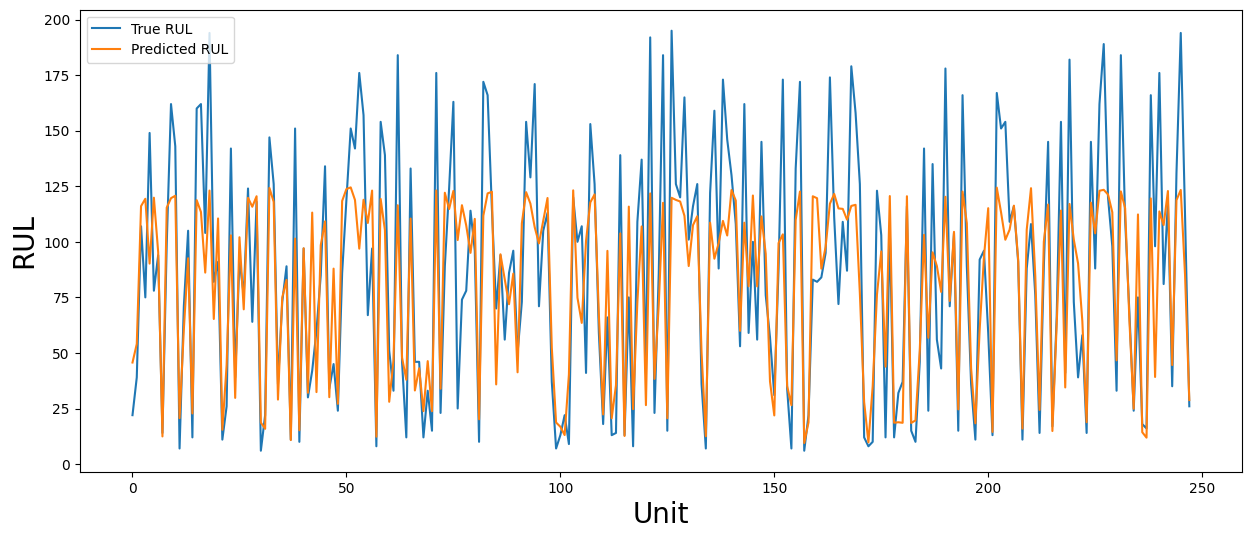

In [247]:
def plot_test_results(true_rul, mean_preds_per_engine):
    plt.rcParams["figure.figsize"] = (15, 6)
    plt.plot(true_rul, label="True RUL")
    plt.plot(mean_preds_per_engine, label="Predicted RUL")
    plt.xlabel("Unit", fontsize=20)
    plt.ylabel("RUL", fontsize=20)
    plt.legend()

plot_test_results(true_rul, mean_preds_per_engine)

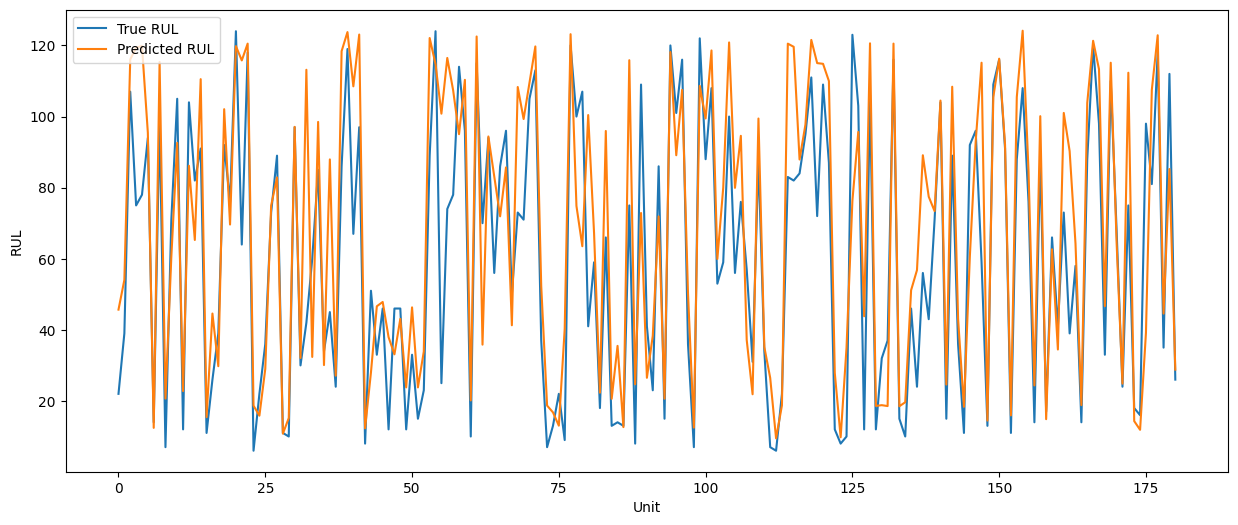

In [248]:
plot_test_results(condensed_true_rul, condensed_mean_preds_per_engine)

In [252]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(list(preds_per_engine.values()))[
    indices_of_last_examples
]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  31.47581211840421


In [253]:
def compute_s_score(rul_true, rul_pred):
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff / 13) - 1, np.exp(diff / 10) - 1))

In [254]:
s_score = compute_s_score(true_rul, mean_preds_per_engine)
print("S-score: ", s_score)

S-score:  9969.233626043213


In [255]:
condensed_s_score = compute_s_score(condensed_true_rul, condensed_mean_preds_per_engine)
print("S-score: ", condensed_s_score)

S-score:  5602.77841590707


In [290]:
import datetime

torch.save(
    model.state_dict(),
    f'{datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")}_model.pth',
)